In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
from pathlib import Path
import numpy as np
import csv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
# Define your font
fpath = Path(mpl.get_data_path(), "fonts/ttf/cmr10.ttf")
fontprop = fm.FontProperties(fname=fpath, size=14)
fontprop_small = fm.FontProperties(fname=fpath, size=10)
COLORS=["#888888", "#B1053A", "#3E4989", "#44AA99", "#CC6677"]
MARKER_LIST = ['o', '^', 's', 'P', 'P']

In [3]:
def get_root():
    # load context data
    path = os.path.abspath('')
    path = os.path.normpath(path)
    components = path.split(os.path.sep)
    src_index = components.index("src")
    components = components[:src_index]
    return os.path.sep.join(components)

In [4]:
def find_overlap_index(all, subset):
    all = all.to_numpy()
    subset = subset[:3]
    for i in range(len(all)-len(subset)+1):
        if (all[i:len(subset)+i] == subset).all():
            return i
    raise ValueError("No overlap found")

In [5]:
def plot_run_comparison(path_to_transfer_learning,
                        path_to_real_world,
                        path_to_baseline,
                        path_to_ode_baseline,
                        attribute_to_plot,
                        models,
                        train_test_split,
                        ylabel,
                        plot_type=["TL"],
                        secondary_attribute=None,
                        save_fig_path=None,
                        ylim=(None, None),
                        xlim=(None, None),
                        text_offset=(0,0),
                        linewidth=2,
                        opacity=0.7):
    for model in models:
        # plt.figure(figsize=(8, 4), dpi=200)

        fig, ax = plt.subplots(nrows=len(plot_type), sharex=True, sharey=True, ncols=1, figsize=(8, 9))
        fig.supxlabel('Time', y = 0.04)
        fig.supylabel(ylabel, x = 0.04)
        plt.tight_layout

        true_file = os.path.join(os.getcwd(), path_to_real_world)
        x_test_file = os.path.join(os.getcwd(), path_to_transfer_learning, f"X_test.npy")
        y_true_file = os.path.join(os.getcwd(), path_to_transfer_learning, f"y_true.npy")
        true_data = pd.DataFrame(pd.read_csv(true_file)[attribute_to_plot])

        file = open(os.path.join(os.getcwd(), path_to_transfer_learning, "features.csv"), "r")
        attribute_idx = list(csv.reader(file))[0].index(attribute_to_plot)
        file.close()

        for plot_idx, plot_type in enumerate(plot_type):
            for i in range(len(true_data)-9):

                # if secondary_attribute:
                #     secondary_attribute = pd.DataFrame(pd.read_csv(true_file)[secondary_attribute]).astype(int)

                x_test_data = np.load(x_test_file)[i, :, attribute_idx].reshape(-1, 1)
                
                y_true_data = np.concatenate((x_test_data[-1], np.load(y_true_file)[i, :, 0])).reshape(-1, 1)

                start_index = find_overlap_index(true_data, x_test_data)
                
                # if input_attributes:
                #     # Plot other input attributes
                #     plt.plot(range(0, start_index+1), input_attributes_data[:start_index+1], color='lightgrey', linestyle=":", label=input_attributes)
                #     plt.plot(range(start_index, len(x_test_data) + start_index), input_attributes_data[start_index:start_index+len(x_test_data)], color=COLORS[0], linestyle=':', label=f"input {input_attributes}", linewidth=linewidth)

                # Plot input attributes that is also being predicted
                # plt.plot(range(0, start_index+1), true_data[:start_index+1], color='lightgrey', linestyle="--", label="new infections")
                # plt.plot(range(start_index+len(x_test_data)+len(y_true_data)-2, len(true_data)), true_data[start_index+len(x_test_data)+len(y_true_data)-2:], color='lightgrey', linestyle="--")
                # plt.plot(range(start_index, len(x_test_data) + start_index), x_test_data, color=COLORS[0], linestyle='--', label=f"input", linewidth=linewidth)
                # plt.plot(range(len(x_test_data)-1 + start_index,
                #                 len(x_test_data) + len(y_true_data)-1 + start_index),
                #                 y_true_data,
                #                 color=COLORS[0],
                #                 label="ground truth",
                #                 linewidth=linewidth)
                ax[plot_idx].plot(range(0, len(true_data)), true_data, color="grey", linestyle="-", linewidth=1, alpha=1)
                

                if "Transfer Learning" in plot_type:
                    # Print Transfer Learning Prediction
                    if i == 0:
                        label = "TL"
                    else:
                        label = None
                    y_pred_file = f"{path_to_transfer_learning}/{model}-y_pred.npy"
                    y_pred_data = np.load(y_pred_file)[i, :, 0].reshape(-1, 1)
                    y_pred_data = np.concatenate((x_test_data[-1].reshape(-1, 1), y_pred_data))
                    ax[plot_idx].plot(range(len(x_test_data)-1+start_index, len(x_test_data)+len(y_true_data)-1+start_index),
                                y_pred_data,
                                label=label,
                                color=COLORS[1],
                                # marker=MARKER_LIST[1],
                                markersize=6,
                                linewidth=linewidth,
                                alpha=opacity if i % 3 == 0 else 0.2
                                )
                    
                
                if "DL baseline" in plot_type:
                    # Print Baseline Prediction
                    if i == 0:
                        label = "DL baseline"
                    else:
                        label = None
                    y_pred_file = f"{path_to_baseline}/{model}-y_pred.npy"
                    y_pred_data = np.load(y_pred_file)[i, :, 0].reshape(-1, 1)
                    y_pred_data = np.concatenate((x_test_data[-1].reshape(-1, 1), y_pred_data))

                    # plot function with label
                    ax[plot_idx].plot(range(len(x_test_data)-1+start_index, len(x_test_data) + len(y_true_data)-1+start_index),
                                y_pred_data,
                                label=label,
                                color=COLORS[2],
                                markersize=6,
                                linewidth=linewidth,
                                alpha=opacity if i % 3 == 0 else 0.2)
                    
            if "ODE baseline" == plot_type:
                # Print Baseline Prediction
                y_pred_data = pd.read_csv(path_to_ode_baseline)[attribute_to_plot] / 1000
                ax[plot_idx].plot(range(6,len(true_data)),
                            y_pred_data[6:],
                            label="ODE baseline",
                            color='#51A537',
                            # marker=MARKER_LIST[2],
                            markersize=6,
                            linewidth=linewidth,
                            alpha=0.8,
                            linestyle="-")
                # if secondary_attribute:
                #     true_data = pd.DataFrame(pd.read_csv(true_file)[secondary_attribute])
                #     y_pred_data = pd.read_csv(path_to_ode_baseline)[secondary_attribute] / 1000000000
                #     # add plot for secondary attribute as plot inside plot
                #     axins = inset_axes(ax[plot_idx], width="45%", height="25%", loc='lower right', borderpad=1)
                #     axins.plot(range(6, len(true_data)), true_data[6:], color="grey", linestyle="--", linewidth=1, alpha=1)
                #     axins.axvline(x = int((1-train_test_split)*len(true_data))-1, color = 'black', linestyle = '-', linewidth = '1')
                #     axins.plot(range(len(true_data)),
                #                 y_pred_data,
                #                 label="ODE baseline (algae)",
                #                 color='#51A537',
                #                 # marker=MARKER_LIST[2],
                #                 markersize=6,
                #                 linewidth=2,
                #                 alpha=0.8,
                #                 linestyle="--")
                #     axins.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
                #     axins.set_ylabel("Algae")

            # Add vertical line to show training cut-off
            ax[plot_idx].axvline(x = int((1-train_test_split)*len(true_data))-1, color = 'black', linestyle = '-', linewidth = '1')
            ax[plot_idx].set_ylabel(plot_type, rotation=270)
            ax[plot_idx].yaxis.set_label_coords(1.02, 0.5)
            ax[plot_idx].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            # ax[plot_idx].legend(loc="upper left")
            # plt.text(int((1-train_test_split)*len(true_data))-text_offset[0], text_offset[1], 'train cutoff', rotation=90, color = 'black', fontproperties=fontprop_small)
            # model = model.replace("PyTorch_Lightning_", "").replace("_", " ").replace("Custom ", "")
            #plt.title(f"Comparison of Transfer Learning and Basic ML Run for {model}", pad=10, fontproperties=fontprop)
            # plt.tight_layout()
        if save_fig_path:
            plt.savefig(save_fig_path+"/algae-rotifers-coherent_predictions.png", format="PNG", dpi=300)
            plt.savefig(save_fig_path+"/algae-rotifers-coherent_predictions.pdf", format="PDF", dpi=300)

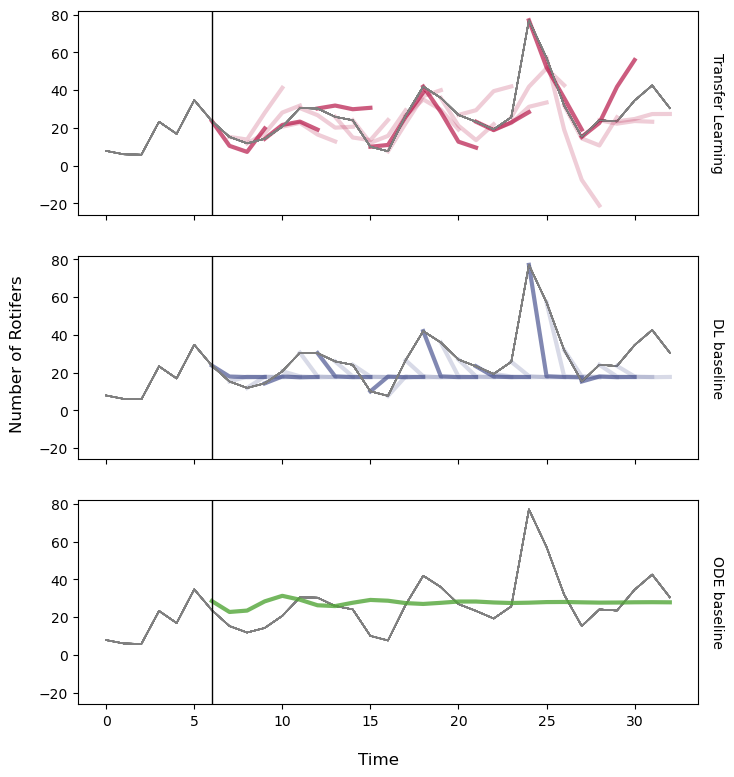

In [6]:
plot_run_comparison(path_to_transfer_learning="TS100_IC2_P3_S42",
                    path_to_real_world="algae-rotifers-coherent.csv",
                    path_to_baseline="baseline_S42",
                    path_to_ode_baseline="algae_rotifiers_coherent_ode_forecast.csv",
                    attribute_to_plot='rotifers',
                    secondary_attribute='algae',
                    ylabel="Number of Rotifers",
                    models=['PyTorch_Lightning_LSTM_Neural_Network'],
                    plot_type=["Transfer Learning", "DL baseline", "ODE baseline"],
                    train_test_split=0.78,
                    text_offset=(0.7, 50),
                    opacity=0.65,
                    save_fig_path=os.getcwd(),
                    linewidth=3
                    )

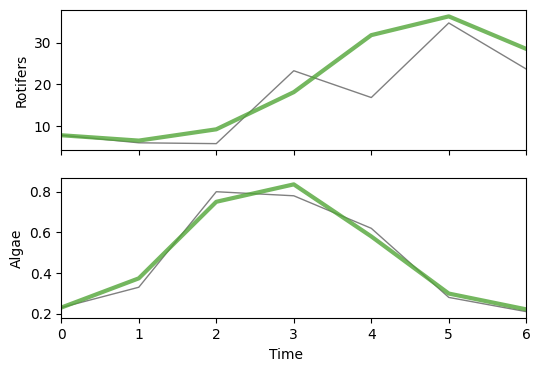

In [14]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), ".."))
from plots import plot_ode_fit

plot_ode_fit(path_to_real_world="algae-rotifers-coherent.csv",
             path_to_ode_baseline="algae_rotifiers_coherent_ode_forecast.csv",
            attribute_to_plot='rotifers',
            secondary_attribute='algae',
            train_test_split=0.78,
            opacity=0.6,
            save_fig_path=os.getcwd(),
            linewidth=3,
            figsize=(6,4),
            xlabel_offset=0.00
            )